In [21]:
from create_model import get_model
from dataset import load_data
from train_model import collate_fn
from visualization import drawrect
from torchvision.ops import nms
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

ModuleNotFoundError: No module named 'analysis'

In [19]:
# Load Model
model = get_model("fasterrcnn", num_classes=4, trainable_backbone_layers=1)
model_path = "G:/My Drive/ACV Project/m_v3_50e.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()

Total params: 41309411
Total trainable params: 32796707


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
# Load dataset
dataset_path = "./../../NBA-Player-Detector-1"
trainset, valset, testset = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=2, 
                                          shuffle=False, 
                                          num_workers=1, 
                                          drop_last=False,
                                          collate_fn = collate_fn)

In [8]:
for (images, labels) in trainloader:
    predictions = model(images)
    N = len(images)
    for i in range(N):
        image = images[i]       # (C, H, W) tensor float
        label = labels[i]       # dict with keys 'boxes', 'labels'
        pred = predictions[i]   # dict with keys 'boxes', 'labels', 'scores'
    break

In [22]:
CLASS_COLORS = {
    1 : (255,0,0),
    2 : (0,255,0),
    3 : (0,0,255)
}

def draw_gt_pred_boxes(image: torch.Tensor, gt: torch.Tensor, pred: torch.Tensor, MIN_PRED_SCORE=0.5):
    """

    Args:
        image (torch.Tensor): torch.float32 shape (C x H x W)
        gt (torch.Tensor): dictionary containing:
            - 'boxes'  -> Tensor of shape (N, 4)
            - 'labels' -> Tensor of shape (N, ) with ints
        pred (torch.Tensor): dictionary containing:
            - 'boxes'  -> Tensor of shape (M, 4)
            - 'labels' -> Tensor of shape (M, ) with ints
            - 'scores' -> Tensor of shape (M, ) with floats
    """

    assert image.dtype == torch.float32
    assert type(gt) == dict
    assert type(pred) == dict

    # Transform image to numpy array of ints and shape (H,W,C)
    vis_image = (image * 255).to(torch.uint8)
    vis_image = vis_image.permute(1,2,0).numpy()

    # Define the list of gt and pred to process
    # TODO check if to apply NMS here
    
    # Predicted boxes
    pred_indices = [i for i in range(len(pred['boxes'])) if pred['scores'][i] >= MIN_PRED_SCORE]
    pred_boxes = [pred['boxes'][i] for i in pred_indices]
    pred_labels = [pred['labels'][i] for i in pred_indices]
    
    # Ground truth
    gt_boxes = gt['boxes'].detach().clone().tolist()
    gt_labels = gt['labels'].detach().clone().tolist()

    # Draw predicted boxes
    for i in pred_indices:
        x_min, y_min, x_max, y_max = pred_boxes[i]
        point1 = (int(x_min), int(y_min))
        point2 = (int(x_max), int(y_max))
        label_id = pred_labels[i].item()
        color = CLASS_COLORS[label_id]
        drawrect(vis_image, point1, point2, color, thickness=4, style='dotted')
    
    # Draw ground truth boxes
    for i in range(len(gt_boxes)):
        x_min, y_min, x_max, y_max = gt_boxes[i]
        point1 = (int(x_min), int(y_min))
        point2 = (int(x_max), int(y_max))
        label_id = gt_labels[i]
        color = CLASS_COLORS[label_id]
        vis_image = cv2.rectangle(vis_image, point1, point2, color, thickness=4)
    
    return vis_image

In [23]:
vis_image = draw_gt_pred_boxes(image, label, pred)

(-0.5, 1919.5, 1079.5, -0.5)

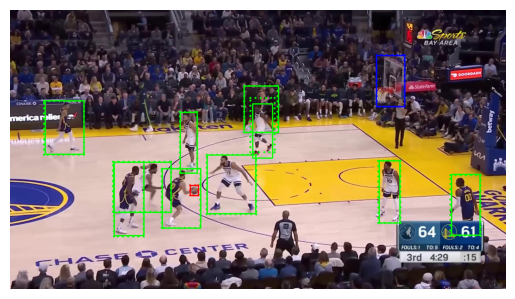

In [24]:
plt.imshow(vis_image)
plt.axis('off')